## Probability Calibration Curve

[Machine Learning with Imbalanced Data - Course]

* In this notebook, we will plot probability calibration curves for logistic regression predictions made from balanced and imbalanced datasets.

* Machine learning classifiers often output probabilities for predictions. However, these probabilities are not always well-calibrated, meaning they do not reflect the true likelihood of an event. For example:

    * A model predicts 90% probability for a class, but in reality, only 70% of those cases are correct.
    * Another model predicts 30% probability, yet 50% of those cases turn out positive.

* Probability calibration curves allow us to visualize if the classifier returns calibrated probabilities.

* Logistic regression returns calibrated probabilities.

* A Probability Calibration Curve (also known as a Reliability Diagram) is used to assess whether the predicted probabilities of a classifier reflect the true likelihood of an event. 
* In an ideal scenario, if a model predicts a probability of 0.7 for a given class, then approximately 70% of such instances should belong to that class.

* Why is Calibration Important?

    * If a model is well-calibrated, then when it predicts a probability of 0.7 for a class, that class should appear in approximately 70% of the cases. Models like Logistic Regression often produce well-calibrated probabilities.
    * Poorly calibrated models can be overconfident (predicting high probabilities when the actual correctness is lower) or underconfident. Compared to Logistic Regression, others like Random Forests or SVMs, may require calibration techniques (e.g., Platt Scaling or Isotonic Regression) to correct their probability estimates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to create artificial data
from sklearn.datasets import make_classification

# to train a model and plot the calibration curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

## Function to create data set

In [2]:
def create_dataset(weights):

    # returns arrays
    X, y = make_classification(
        n_samples=10000,
        n_features=10,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[weights],  # to balance (or not) the classes
        class_sep=1,  # how separated the classes are
        random_state=1)

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X, y

## Create a balanced dataset

The 2 classes are fairly well separated for the demonstration.

In [3]:
X, y = create_dataset(weights=0.5)

# show dataset
X.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.658803,0.829669,-0.144299,1.023428,-1.202420,0.143194,1.442737,0.105750,0.639316,-0.015008
1,-0.257548,2.483056,0.379567,-2.254821,-0.072324,1.609488,-0.660558,0.463669,-0.244913,0.311547
2,-0.308108,1.457985,0.369361,1.295003,-1.813459,0.200404,0.199826,-0.401978,-0.365098,0.533825
3,-0.023793,1.319102,-1.614718,-0.397581,-0.092439,0.789002,-0.261107,-0.750842,1.650654,1.747664
4,1.078281,1.551971,-1.647722,2.509523,0.314624,-1.146409,-1.244661,-0.469266,1.982250,0.422053


In [4]:
# number of observations per class

y.value_counts()

0    5000
1    5000
Name: count, dtype: int64

In [5]:
# balancing ratio

y.value_counts() / len(y)

0    0.5
1    0.5
Name: count, dtype: float64

### Separate into train and test sets

In [6]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 10), (3000, 10))

In [7]:
# balancing ratio: train set

y_train.value_counts() / len(X_train)

1    0.5
0    0.5
Name: count, dtype: float64

In [8]:
# number of observations per class

y_train.value_counts()

1    3500
0    3500
Name: count, dtype: int64

You can go ahead and check the balancing ratio for the test set, should be similar.

### Train Logistic Regression

In [9]:
# Logistic Regression on balanced dataset

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

# score the test set
probs = logit.predict_proba(X_test)[:, 1]

## Calibration Curve

https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html#sklearn.calibration.calibration_curve

- Sorts the probability values into bins
- Determines the true positive fraction in those bins

* In the probability calibration curve, mean_predicted_value and fraction_of_positives are key values used to plot the curve:

    * mean_predicted_value (X-axis of the plot)
        This represents the average predicted probability for each bin.
        The predicted probabilities from the model are grouped into bins (e.g., [0.0-0.1], [0.1-0.2], ..., [0.9-1.0]).
        For each bin, we calculate the mean of the predicted probabilities within that bin.

    * fraction_of_positives (Y-axis of the plot)
        This represents the actual fraction of positive samples (class 1) in each bin.
        For each bin, we check the proportion of samples that actually belong to class 1.
    
* Example Calculation

* Imagine we have the following predicted probabilities and true labels:
* Sample	Predicted Probability	True Label
* 1	            0.05	            0
* 2	            0.10	            1
* 3	            0.15	            1
* 4	            0.20	            0
* 5	            0.85	            1
* 6	            0.90	            1   

* If we divide them into 3 bins:

    * Bin 1 (0.0 - 0.3)
        Mean predicted probability: (0.05 + 0.10 + 0.15 + 0.20) / 4 = 0.125
        Fraction of positives: 2 out of 4 are class 1 → 2/4 = 0.5
    * Bin 2 (0.3 - 0.6)
        No samples here.
    * Bin 3 (0.6 - 1.0)
        Mean predicted probability: (0.85 + 0.90) / 2 = 0.875
        Fraction of positives: 2 out of 2 → 1.0

* These values are then plotted to create the probability calibration curve.

In [10]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, probs, n_bins=10, strategy='uniform')

len(mean_predicted_value), len(fraction_of_positives)

(10, 10)

In [11]:
# mean probability of each interval / bin

mean_predicted_value

array([0.03588248, 0.14189299, 0.24567388, 0.35046407, 0.45454455,
       0.54483823, 0.65526564, 0.75087511, 0.85704375, 0.97653893])

In [12]:
# fraction of observations of the minority class
# in each interval of probability

fraction_of_positives

array([0.03699422, 0.13919414, 0.19565217, 0.30833333, 0.44036697,
       0.45348837, 0.67      , 0.79166667, 0.88541667, 0.98633018])

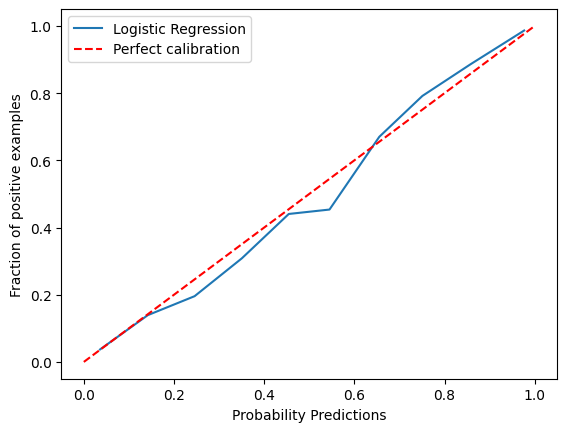

In [13]:
# plot calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, label='Logistic Regression')

# plot perfect calibration line
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),
         linestyle='--', color='red', label='Perfect calibration')

# add labels and legends
plt.xlabel('Probability Predictions')
plt.ylabel('Fraction of positive examples')
plt.legend(loc='upper left')
plt.show()

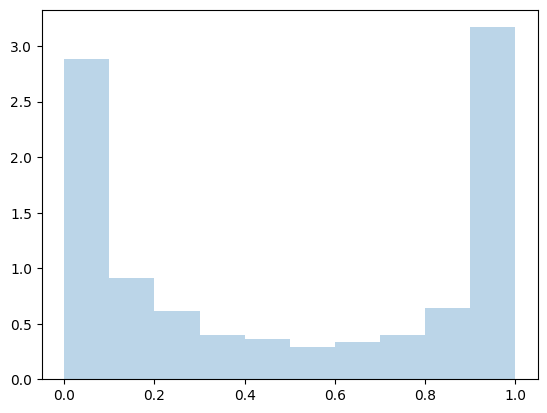

In [14]:
# plot number of observation per prediction interval

plt.hist(probs, range=(0, 1), bins=10, density=True, stacked=True, alpha=0.3)
plt.show()

In [15]:
# bring all together

def plot_calibration_curve(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='Logistic Regression')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

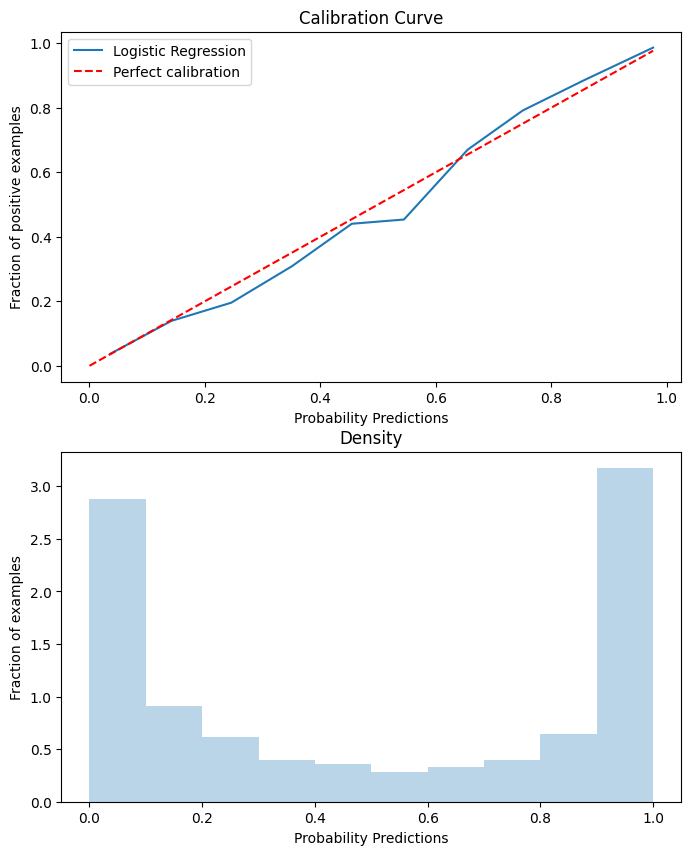

In [16]:
plot_calibration_curve(y_test, probs, bins=10, strategy='uniform')

### Change number of probability bins

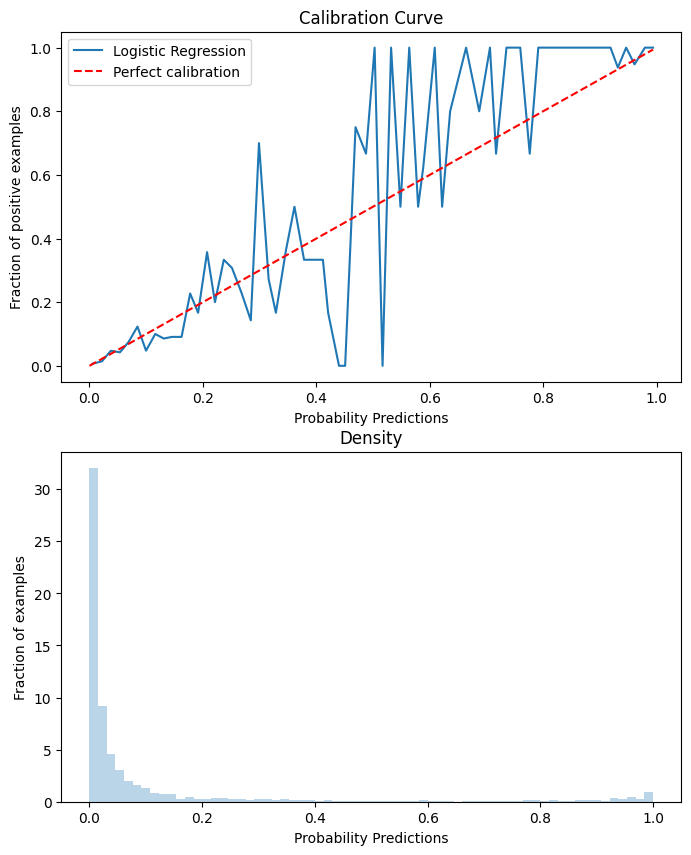

In [32]:
plot_calibration_curve(y_test, probs, bins=65, strategy='uniform')

The less observations we have per interval, the harder to obtain a reliable probability vs positive fraction estimate. This, the functions seems more noisy.

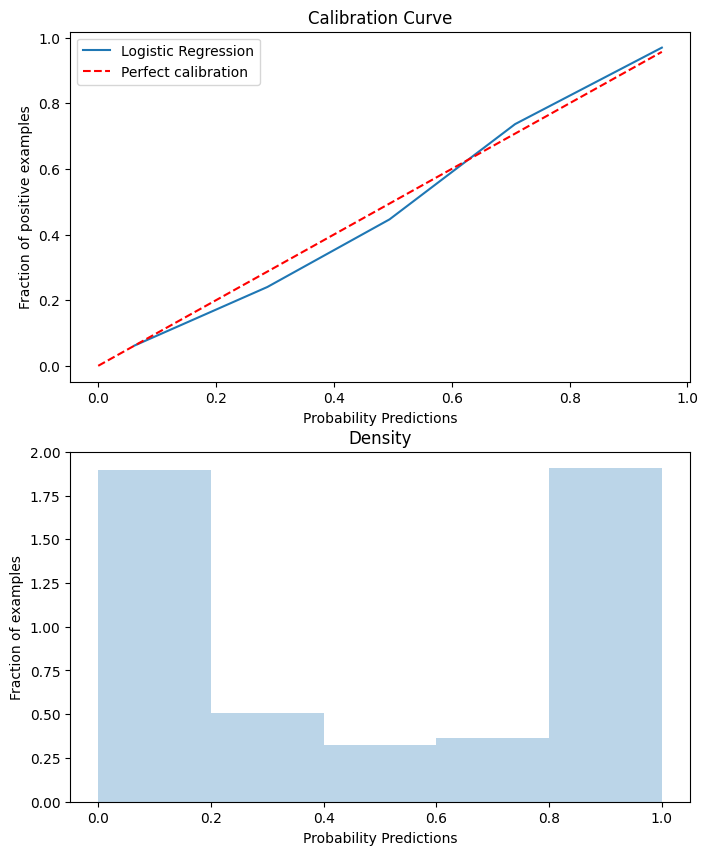

In [18]:
plot_calibration_curve(y_test, probs, bins=5, strategy='uniform')

* The calibration curve should be close to the diagonal, indicating that the predicted probabilities match the actual likelihood.
* Logistic Regression is usually well-calibrated by default, so it should perform well.

**HOMEWORK 1**: Train another model, different from Logistic Regression and determine the calibration curve. Are probabilities calibrated?

## Imbalanced dataset

In [19]:
X, y = create_dataset(weights=0.9)

# number of observations per class
y.value_counts()

0    8954
1    1046
Name: count, dtype: int64

In [20]:
# balancing ratio

y.value_counts() / len(y)

0    0.8954
1    0.1046
Name: count, dtype: float64

### Separate train and test

In [21]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 10), (3000, 10))

### Train Logistic Regression

In [33]:
# Logistic Regression on imbalanced dataset

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

# score the test set
probs = logit.predict_proba(X_test)[:, 1]

## Calibration Curve

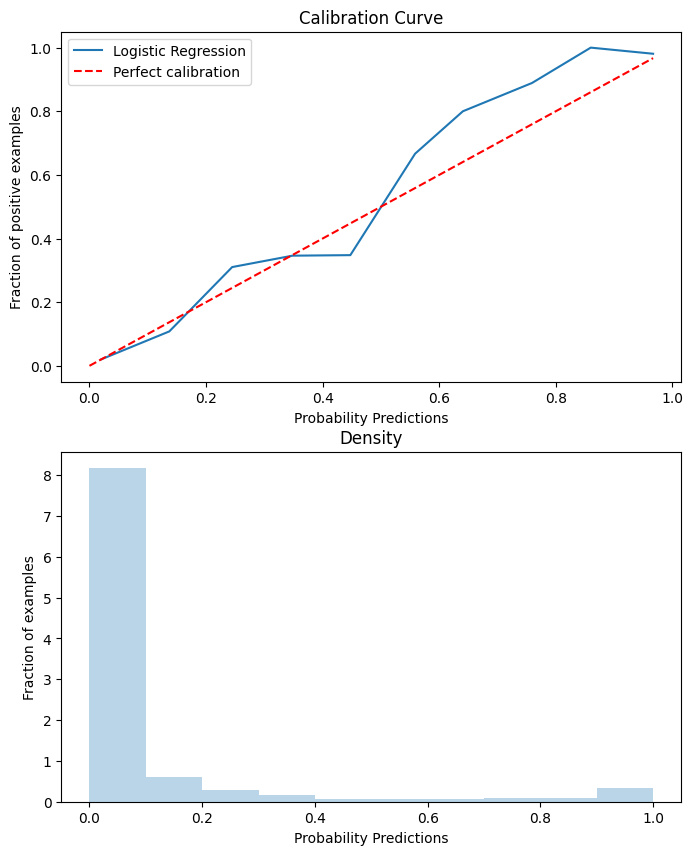

In [36]:
plot_calibration_curve(y_test, probs, bins=10, strategy='uniform')

* The Probability Calibration Curve helps diagnose whether probability estimates are reliable.
* Balanced datasets tend to yield better-calibrated probabilities.
* Imbalanced datasets may require re-calibration techniques to correct overconfidence in predictions.

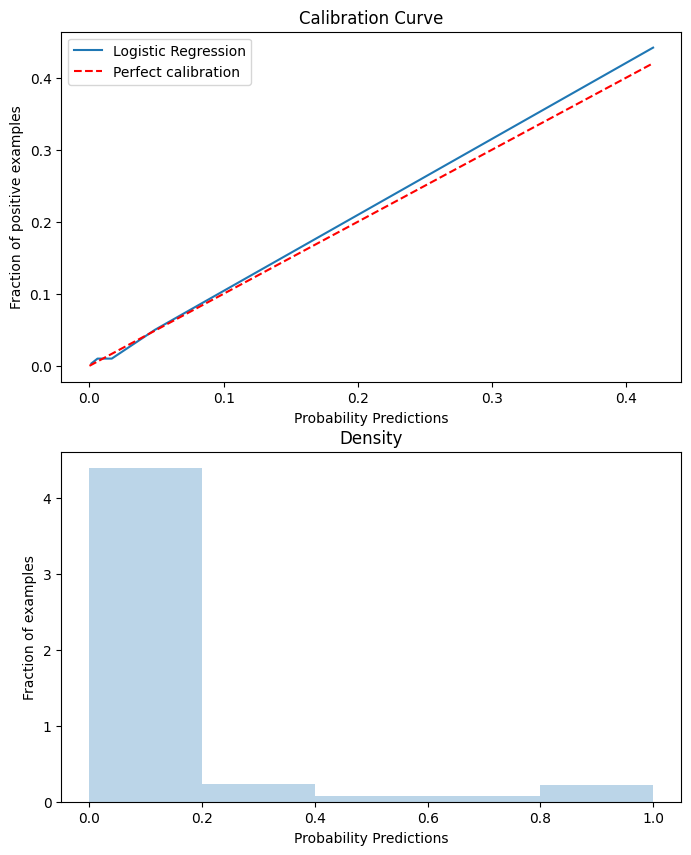

In [24]:
plot_calibration_curve(y_test, probs, bins=5, strategy='quantile')

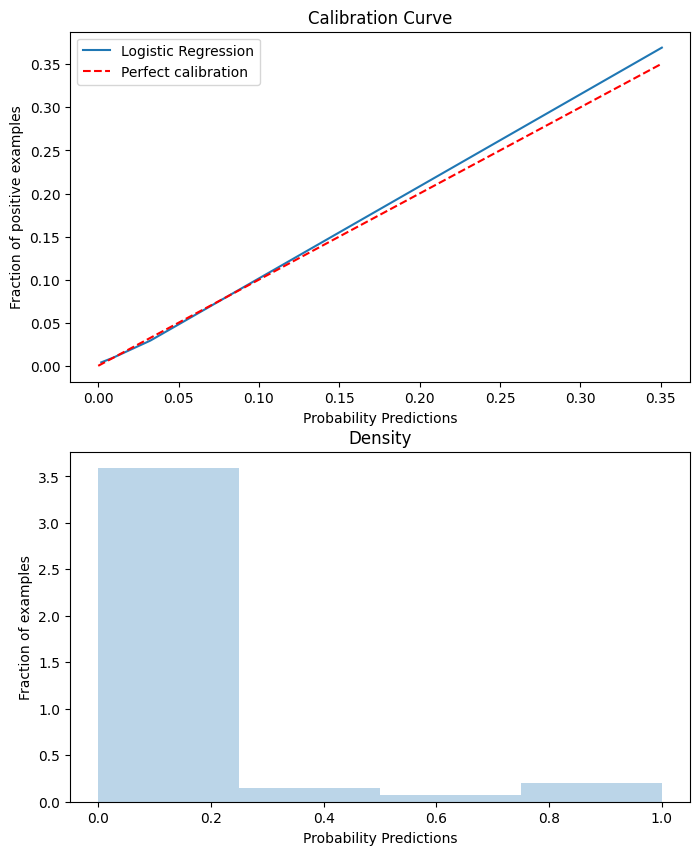

In [25]:
plot_calibration_curve(y_test, probs, bins=4, strategy='quantile')

The predictions do not seem to be balanced. Most likely it is because we do not have a sufficient number of observations of the positive class, to accurately determine the fraction of positives.

**HOMEWORK 2**: increase the number of observations in the dataset, and if you want as well, the balancing ratio, and observe the change in the calibration curve. What do you see?

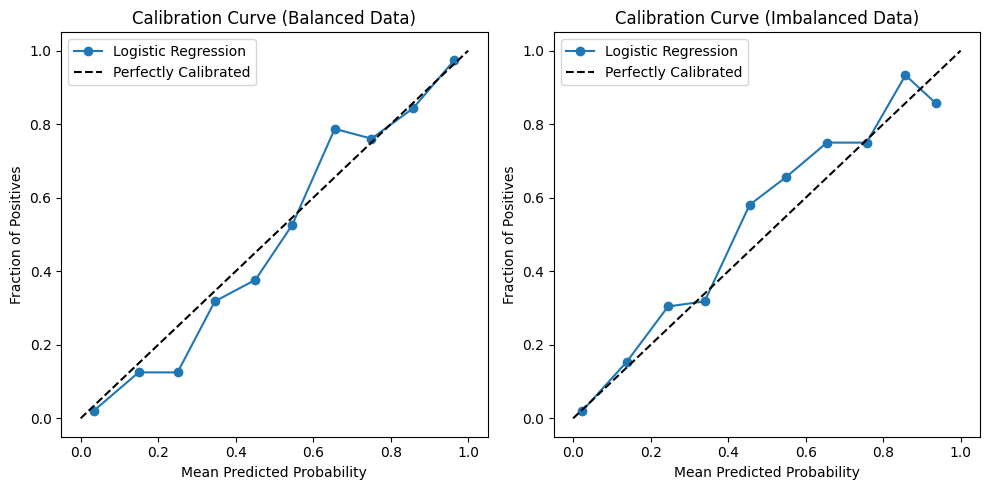

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

#-----------------------

# Balanced dataset (50-50 class distribution)
X_bal, y_bal = make_classification(n_samples=5000, n_features=10, n_classes=2, 
                                   weights=[0.5, 0.5], random_state=42)

# Imbalanced dataset (90-10 class distribution)
X_imb, y_imb = make_classification(n_samples=5000, n_features=10, n_classes=2, 
                                   weights=[0.9, 0.1], random_state=42)

# Split into training and testing sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.3, random_state=42)

#-----------------------

# Train Logistic Regression models
clf_bal = LogisticRegression()
clf_imb = LogisticRegression()

clf_bal.fit(X_train_bal, y_train_bal)
clf_imb.fit(X_train_imb, y_train_imb)

# Predict probabilities
prob_bal = clf_bal.predict_proba(X_test_bal)[:, 1]  # Probabilities for class 1
prob_imb = clf_imb.predict_proba(X_test_imb)[:, 1]  # Probabilities for class 1


#-----------------------

# Compute calibration curves
fraction_of_positives_bal, mean_predicted_value_bal = calibration_curve(y_test_bal, prob_bal, n_bins=10)
fraction_of_positives_imb, mean_predicted_value_imb = calibration_curve(y_test_imb, prob_imb, n_bins=10)

#-----------------------

plt.figure(figsize=(10, 5))

# Plot for balanced dataset
plt.subplot(1, 2, 1)
plt.plot(mean_predicted_value_bal, fraction_of_positives_bal, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Balanced Data)")
plt.legend()

# Plot for imbalanced dataset
plt.subplot(1, 2, 2)
plt.plot(mean_predicted_value_imb, fraction_of_positives_imb, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Imbalanced Data)")
plt.legend()

plt.tight_layout()
plt.show()




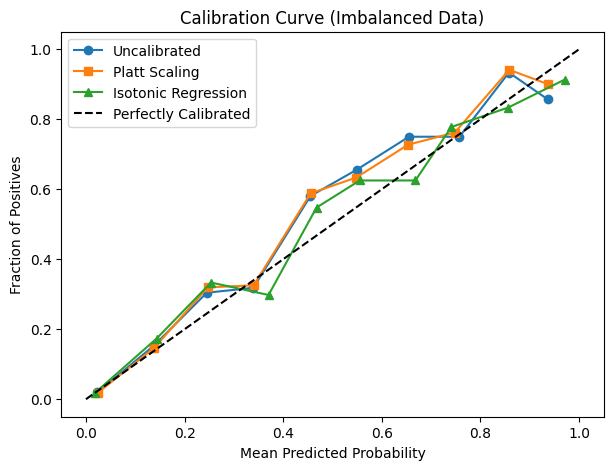

In [27]:
from sklearn.calibration import CalibratedClassifierCV


# Train Logistic Regression Model
clf_imb = LogisticRegression()
clf_imb.fit(X_train_imb, y_train_imb)

# Apply Platt Scaling (sigmoid) and Isotonic Regression
calibrated_platt = CalibratedClassifierCV(clf_imb, method='sigmoid', cv=5)  # Platt Scaling
calibrated_iso = CalibratedClassifierCV(clf_imb, method='isotonic', cv=5)   # Isotonic Regression

calibrated_platt.fit(X_train_imb, y_train_imb)
calibrated_iso.fit(X_train_imb, y_train_imb)

# Get calibrated probabilities
prob_imb_platt = calibrated_platt.predict_proba(X_test_imb)[:, 1]
prob_imb_iso = calibrated_iso.predict_proba(X_test_imb)[:, 1]

# Compute calibration curves
frac_pos_imb_platt, mean_prob_imb_platt = calibration_curve(y_test_imb, prob_imb_platt, n_bins=10)
frac_pos_imb_iso, mean_prob_imb_iso = calibration_curve(y_test_imb, prob_imb_iso, n_bins=10)


plt.figure(figsize=(7, 5))

# Original Calibration Curve
plt.plot(mean_predicted_value_imb, fraction_of_positives_imb, marker='o', label="Uncalibrated")

# Platt Scaling Calibration Curve
plt.plot(mean_prob_imb_platt, frac_pos_imb_platt, marker='s', label="Platt Scaling")

# Isotonic Regression Calibration Curve
plt.plot(mean_prob_imb_iso, frac_pos_imb_iso, marker='^', label="Isotonic Regression")

# Perfect Calibration Line
plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Perfectly Calibrated")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Imbalanced Data)")
plt.legend()
plt.show()


* Interpretation

    * Before Calibration (Uncalibrated Model)
        The curve deviates from the diagonal, indicating poor probability estimates.
    * Platt Scaling (Sigmoid)
        It smooths the probabilities but may still struggle with non-monotonic miscalibration.
    * Isotonic Regression
        Produces a better-aligned curve, especially when the original curve was highly misaligned.

* Which Method to Choose?

    * If miscalibration is sigmoid-shaped, use Platt Scaling.
    * If miscalibration is non-monotonic, use Isotonic Regression.

* Probability calibration techniques adjust predicted probabilities so they better reflect the actual likelihood of events. Two common calibration methods are:

    * Platt Scaling (Logistic Regression-based method)
    * Isotonic Regression (Non-parametric approach)


* Platt Scaling (Sigmoid Calibration)

    * Platt Scaling is a logistic regression model applied to the predicted probabilities of a classifier. It assumes that the miscalibration follows a sigmoid-shaped curve and adjusts the probabilities accordingly.

* Working:
    * Instead of directly using the raw model probabilities, Platt Scaling applies a logistic transformation:

$$ P(y=1 \mid x) = \frac{1}{1 + e^{(A \cdot f(x) + B)}} $$


* Where:

    * f(x) = raw model output (logits or uncalibrated probabilities).
    * A and B = parameters learned using logistic regression on a held-out validation set.

* This function maps raw probabilities to a new probability range that better aligns with actual event frequencies.

* When to Use Platt Scaling

    * Use when miscalibration follows a sigmoid shape (i.e., probabilities are overly confident).
    * Works well for SVMs, Random Forests, and Boosted Trees.
    * Suitable for small datasets because it uses only two parameters (A & B).

* Not ideal for non-monotonic miscalibration (where probabilities fluctuate up/down irregularly).
* May underperform when training data is highly imbalanced.

* Isotonic Regression (Non-Parametric Calibration)
    * Isotonic Regression is a non-parametric technique that learns a monotonic mapping between raw model probabilities and actual event probabilities.
    * Unlike Platt Scaling, which assumes a sigmoid-shaped miscalibration, Isotonic Regression is more flexible and does not assume a specific function shape.

* How It Works
    * The method divides the probability space into bins and fits a non-decreasing function that maps predicted probabilities to true frequencies.
    * This is done by solving:

$$ \min \sum (g(x_i) - y_i)^2 $$

* The function g(x)g(x) is constrained to be monotonic (i.e., it never decreases).
* The algorithm uses pool adjacent violators (PAV) algorithm to ensure monotonicity.

* When to Use Isotonic Regression
    * Works well when miscalibration is complex and non-monotonic.
    * Handles imbalanced datasets better than Platt Scaling.
    * More flexible than Platt Scaling, leading to better probability estimates.

* Requires more data than Platt Scaling to avoid overfitting.
* Can produce overconfident probabilities when applied to small datasets.
